# Оценка повышения уровня благополучия детей по всему миру

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше столбцов

In [3]:
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6

In [4]:
df = pd.read_csv('./stud_math.csv')

In [5]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [6]:
df.shape

(395, 30)

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [9]:
# Сколько нулевых значений
df.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
pstatus                45
medu                    3
fedu                   24
mjob                   19
fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

# Первые мысли о дата фрейме:

1. Присутствуют нулевые значения в большинстве колонок, но их не так много.
2. Данные хорошо сгруппированы, информативные

# Вспомогательные функции:

In [10]:
def get_statistical_borders(column):
    '''
    The method calculates statistical borders. The values beyond the borders are garbage.

    Parameters:
    column (str): A name of a column.

    Returns:
    (float32, float32): Returns statistical borders from-to.
    '''

    perc25 = df[column].quantile(q=0.25)
    perc75 = df[column].quantile(q=0.75)
    IQR = perc75 - perc25

    take_from = perc25 - 1.5*IQR
    take_to = perc75 + 1.5*IQR

    return take_from, take_to


def filter_statistical_outliers(column, group_size):
    '''
    The method calculates the count of values in groups and returns only the groups where count more or equal to 'group_size'.

    Parameters:
    column (str): A name of a column.
    group_size (int): group size.

    Returns:
    (pandas.DataFrame): returns filtered data frame.
    '''

    return df[
        df[column].isin(
            df[column].value_counts()[
                df[column].value_counts() >= group_size
            ].index
        )
    ]


def show_grouped_info(column):
    '''
    The method shows the main information about a column.

    Parameters:
    column (str): A name of a column.
    '''

    display(pd.DataFrame(df[column].value_counts()))
    df.loc[:, [column]].info()


def change_column_type(column, new_type):
    '''
    The method changes the type of a column.

    Parameters:
    column (str): A name of a column.
    new_type(type): New column type.
    '''

    df[column] = df[column].astype(new_type)


def populate_none_values(column, new_val):
    '''
    The method populates None values.

    Parameters:
    column (str): A name of a column.
    new_val(object): The new value for all None values.
    '''

    df.loc[df[column].isna(), column] = new_val


def get_boxplot(column):
    '''
    The method draws the box plot for a particular column.

    Parameters:
    column (str): A name of a column.
    '''

    fig, ax = plt.subplots(figsize=(14, 4))

    sns.boxplot(
        x=column,
        y='score',
        ax=ax,
        data=df.loc[
            df.loc[:, column].isin(
                df.loc[:, column].value_counts().index[:10]
            )
        ]
    )

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column):
    '''
    The method finds statistically significant columns.

    Parameters:
    column (str): A name of a column.
    '''

    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))

    for comb in combinations_all:
        if ttest_ind(
            df.loc[df.loc[:, column] == comb[0], 'score'],
            df.loc[df.loc[:, column] == comb[1], 'score']
        ).pvalue <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# 1. Провести первичную обработку данных.

Просмотр колонок по отдельности и приведение данных каждой колонки в удобное для анализа состояние:

## school

In [11]:
show_grouped_info('school')

,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Данные чистые, нет пустых значений. Данные только по двум школам или по двум сетям школ.

## sex

In [12]:
show_grouped_info('sex')

,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Данные чистые, нет пустых значений. Приблизительно одинаковое количество обоих полов.

## age

In [13]:
show_grouped_info('age')

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


Данные чистые, нет пустых значений. В сгруппированном виде видно что количество данных в возрастной категории [20, 21, 22] очень низкое. Возможно будет целесообразно исключить возрастные категории [20, 21, 22]. В колонке только числа, приведем тип колонки к Int32

In [14]:
change_column_type('age', np.float32)

## address

In [15]:
show_grouped_info('address')

,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Есть нулевые значения (17 штук). Количество учащихся в городе приобладает. Так как учащихся в городе в 3.5 раза больше, можно заполнить пропущенные поля в этом же соотношении.

In [16]:
indexes_for_U = df[df['address'].isna()]['address'].head(13).index

# городские учащиеся
df.loc[indexes_for_U, 'address'] = 'U'

# учащиеся за городом
df.loc[df[df['address'].isna()]['address'].index, 'address'] = 'R'

## famsize

In [17]:
show_grouped_info('famsize')

,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Колонка famsize содержит 27 нулевых значений. Попробуем заполнить пропуски в соотношении 1 к 2.5 для GT3 и LE3.

In [18]:
indexes_for_GT3 = df[df['famsize'].isna()]['famsize'].head(20).index

# GT3
df.loc[indexes_for_GT3, 'famsize'] = 'GT3'

# LE3
df.loc[df[df['famsize'].isna()]['famsize'].index, 'famsize'] = 'LE3'

## Medu

In [19]:
show_grouped_info('medu')

,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце только цифры, логичнее его будет заменить на float32. Три значения пропущено, скорее всего у этих людей нет никакого образования.

In [20]:
change_column_type('medu', np.float32)

In [21]:
populate_none_values('medu', 0)

## Fedu

In [22]:
show_grouped_info('fedu')

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце только цифры, логичнее его будет заменить на Int32. Так-же 23 значения пропущено, скорее всего у этих людей нет никакого образования. Есть одно аномальное значение равное 40. Предположительно это ошибка и человек хотел написать 4, заменим 40 на 4.

In [23]:
df.loc[df['fedu'] == 40, 'fedu'] = 4

In [24]:
change_column_type('fedu', np.float32)

In [25]:
populate_none_values('fedu', 0)

## Mjob

In [26]:
show_grouped_info('mjob')

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 18 пропущенных значений, предположительно человек не работает. Пока оставим все как есть

## Fjob

In [27]:
show_grouped_info('fjob')

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 36 пропущенных значений, предположительно человек не работает. Пока оставим все как есть.

## reason

In [28]:
show_grouped_info('reason')

,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 17 пропущенных значений.

## guardian

In [29]:
show_grouped_info('guardian')

,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В столбце 29 пропущенных значений.

## traveltime

In [30]:
show_grouped_info('traveltime')

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце 26 постых значений. Установим у них среднее значение. В столбце только целые числа, приведем тип столбца в float32.

In [31]:
change_column_type('traveltime', np.float32)

In [32]:
traveltime_mean = df[~df['traveltime'].isna()]['traveltime'].mean()
traveltime_mean = round(traveltime_mean, 0)

populate_none_values('traveltime', traveltime_mean)

## studytime

In [33]:
show_grouped_info('studytime')

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Содержит 7 нулевых значений. Возможно ребенок не учиться в свободное от школы время либо проводит очень мало времени за учебой, отнесем его к группе 1. В столбце только целые числа, приведем тип столбца в float32.

In [34]:
change_column_type('studytime', np.float32)

In [35]:
populate_none_values('studytime', 1)

## failures

In [36]:
show_grouped_info('failures')

,failures
0.0,293
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  373 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Пустых 19 значений, приведем к 0, это более вероятно. Приведем поле к float32, так как колонка числовая.

In [37]:
change_column_type('failures', np.float32)

In [38]:
populate_none_values('failures', 0)

## schoolsup

In [39]:
show_grouped_info('schoolsup')

,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [40]:
populate_none_values('schoolsup', 'no')

## famsup

In [41]:
show_grouped_info('famsup')

,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [42]:
populate_none_values('famsup', 'no')

## paid

In [43]:
show_grouped_info('paid')

,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [44]:
populate_none_values('paid', 'no')

## activities

In [45]:
show_grouped_info('activities')

,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [46]:
populate_none_values('activities', 'no')

## nursery

In [47]:
show_grouped_info('nursery')

,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [48]:
populate_none_values('nursery', 'no')

## studytime, granular

Колонка выглядит не информативной. Удаляем из дата сета.

In [49]:
df.drop(['studytime, granular'], inplace=True, axis=1)

## higher

In [50]:
show_grouped_info('higher')

,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [51]:
populate_none_values('higher', 'no')

## internet

In [52]:
show_grouped_info('internet')

,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [53]:
populate_none_values('internet', 'no')

## romantic

In [54]:
show_grouped_info('romantic')

,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no. Пустые значения приведем к no.

In [55]:
populate_none_values('romantic', 'no')

## famrel

In [56]:
show_grouped_info('famrel')

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  368 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. В колонке только целые числа, приведем их к float32. -1 некоректное значение для данного дата фрейма, скорее всего отношения в семье плохие, приведем данное значение к 1. Пустые поля приведем к средней.

In [57]:
df.loc[df['famrel'] == -1, 'famrel'] = 1

In [58]:
change_column_type('famrel', np.float32)

In [59]:
famrel_mean = df[~df['famrel'].isna()]['famrel'].mean()
famrel_mean = round(famrel_mean, 0)

populate_none_values('famrel', famrel_mean)

## freetime

In [60]:
show_grouped_info('freetime')

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  384 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля заполним средней. В колонке только числа, приведем их к float32.

In [61]:
change_column_type('freetime', np.float32)

In [62]:
freetime_mean = df[~df['freetime'].isna()]['freetime'].mean()
freetime_mean = round(freetime_mean, 0)

populate_none_values('freetime', freetime_mean)

## goout

In [63]:
show_grouped_info('goout')

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   387 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к Int32

In [64]:
df['goout'] = df['goout'].astype('Int32')

## health

In [65]:
show_grouped_info('health')

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к Int32

In [66]:
change_column_type('health', np.float32)

## absences

In [67]:
show_grouped_info('absences')

,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  383 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Колонка содержит только числа. Приведем колонку к float32. Пустые поля заполним средней.

In [68]:
change_column_type('absences', np.float32)

In [69]:
absences_mean = df[~df['absences'].isna()]['absences'].mean()
absences_mean = round(absences_mean, 0)

populate_none_values('absences', absences_mean)

## score

In [70]:
show_grouped_info('score')

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Колонка содержит только числа. Приведем ее к типу float32. Колонка является ключевой для оценки успеваемости студентов, возможно стоит удалить записи с пустыми значениями в данной колонке.

In [71]:
# удалим записи с пустыми значениями в данной колонке
df.dropna(subset=['score'], inplace=True)

# приведем колонку к типу Int32
change_column_type('score', np.float32)

# 2. Посмотреть на распределение признака для числовых переменных, устраните выбросы.

In [72]:
numeric_df = df.loc[:, df.dtypes == np.float32]

print('Для анализа возьмем числовые столбцы:', ', '.join(numeric_df.columns))

Для анализа возьмем числовые столбцы: age, medu, fedu, traveltime, studytime, failures, famrel, freetime, health, absences, score


## age

Во время исследования данной колонки было замечано малое количество человек в возрастных группах: [20, 21, 22].

<AxesSubplot:>

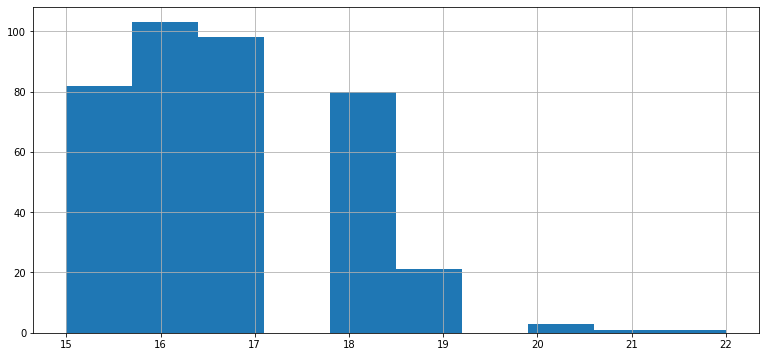

In [73]:
df['age'].hist()

Удалим выбросы.

In [74]:
# Отберем возрастные группы в которых количество участников больше или равно 10
df = filter_statistical_outliers('age', 10)

## traveltime

Учащихся далеко от дома меньше всего. Их всего 7. Пока оставим.

## studytime

Учащихся более 4 часов 27 человек, это сильно меньше остальных, но не так уж и мало.

## failures

Учащихся без неудач сильно больше чем тех, у кого было [1, 2, 3] неудачи. Но в этих группах все же не мало детей. Оставляем как есть.

## famrel

В этой колонке так же присутствует сдвиг, но количество детей в группах [1, 2] не мало. 8 и 17 детей соответственно. Оставляем пока как есть.

## freetime

В этой колонке так же присутствует сдвиг, но количество детей в группах [1] не мало. Оставляем пока как есть.

## absences

В этой колонке есть два значения сильно выделющиеся от остальных: [212, 385]. Посмотрим гистограмму.

<AxesSubplot:>

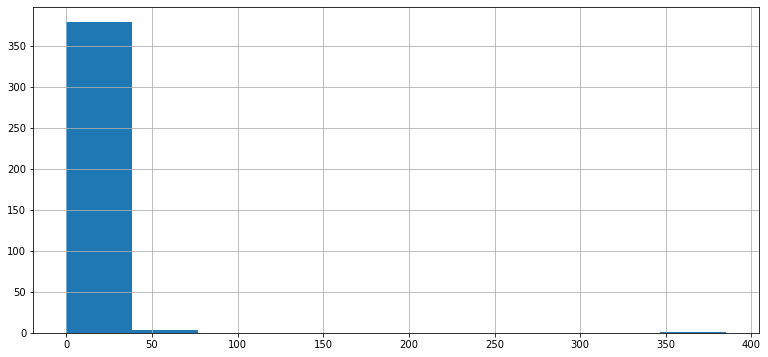

In [75]:
df['absences'].hist()

Колонка содержит выбросы. Отфильтруем данные, удалим выбросы.

In [76]:
take_from, take_to = get_statistical_borders('absences')

<AxesSubplot:>

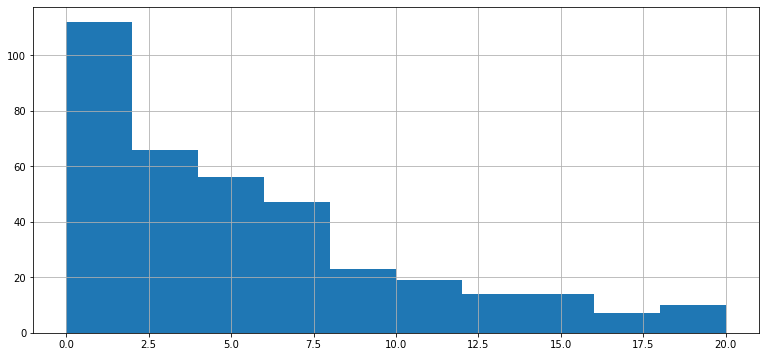

In [77]:
df = df[df['absences'].between(take_from, take_to)]

df['absences'].hist()

# 3. Провести корреляционный анализ количественных переменных.

Выясним, какие столбцы коррелируют с оценкой по математике. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить.

Корреляции рассмотрим только для числовых столбцов.

Используем для наглядности матрицу корреляций:

In [78]:
corr = df.corr()
corr

,age,medu,fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.169725,-0.112388,0.093905,0.014641,0.110722,0.008627,-0.008568,0.126416,-0.048643,0.149410,-0.181492
medu,-0.169725,1.000000,0.493217,-0.153133,0.098679,-0.251368,-0.004378,0.051009,0.062245,-0.035857,0.061294,0.231096
fedu,-0.112388,0.493217,1.000000,-0.058025,-0.012959,-0.240004,0.004408,-0.025246,0.040629,-0.020618,-0.026492,0.104369
traveltime,0.093905,-0.153133,-0.058025,1.000000,-0.089898,0.050059,-0.024230,-0.000762,0.041498,-0.037241,-0.042798,-0.056494
studytime,0.014641,0.098679,-0.012959,-0.089898,1.000000,-0.172767,0.038762,-0.126791,-0.039924,-0.084594,-0.080257,0.102709
failures,0.110722,-0.251368,-0.240004,0.050059,-0.172767,1.000000,-0.065149,0.046507,0.071631,0.133307,0.063609,-0.351631
famrel,0.008627,-0.004378,0.004408,-0.024230,0.038762,-0.065149,1.000000,0.149896,0.062054,0.085898,-0.094113,0.060826
freetime,-0.008568,0.051009,-0.025246,-0.000762,-0.126791,0.046507,0.149896,1.000000,0.284725,0.058125,0.094928,0.034006
goout,0.126416,0.062245,0.040629,0.041498,-0.039924,0.071631,0.062054,0.284725,1.000000,0.001164,0.106890,-0.110143
health,-0.048643,-0.035857,-0.020618,-0.037241,-0.084594,0.133307,0.085898,0.058125,0.001164,1.000000,-0.001871,-0.080475


С полученной корреляцией построим heatmap для визуализации

<AxesSubplot:>

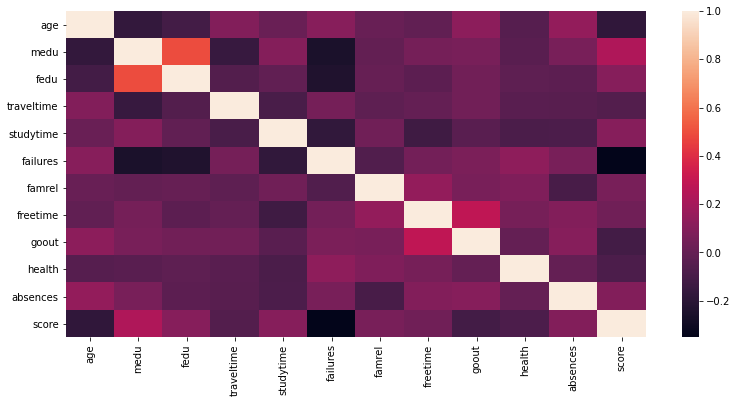

In [79]:
sns.heatmap(corr)

# 4. Отобрать не коррелирующие переменные.

Итак, мы видим что **age, failures, traveltime, goout, health** не коррелируются со **score**.

# 5. Проанализировать номинативные переменные и устраните те, которые не влияют на предсказываемую величину (`score`)

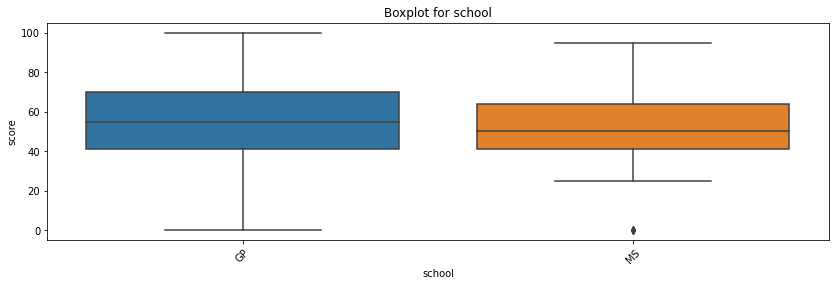

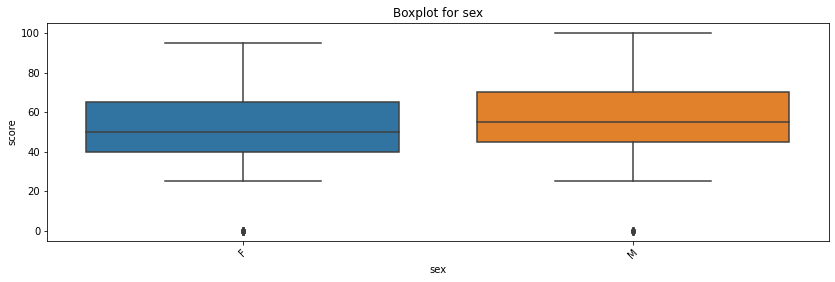

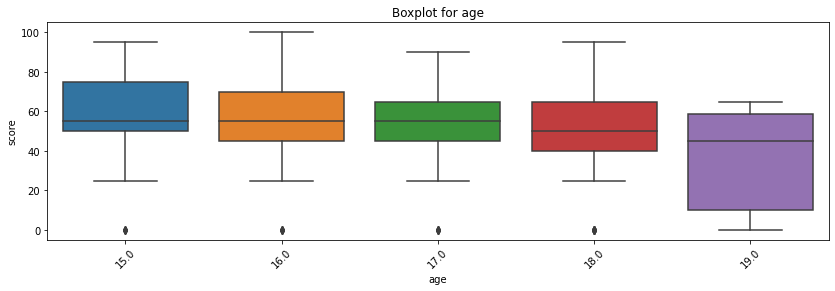

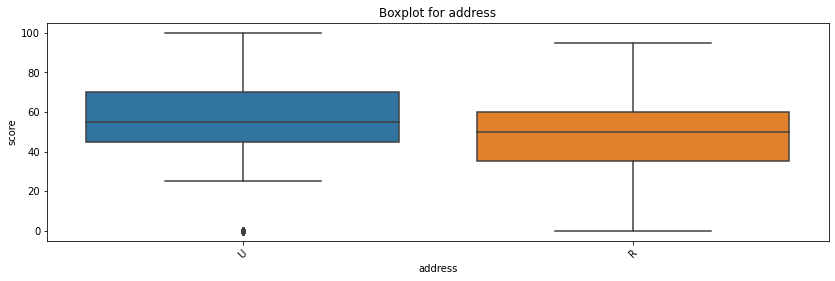

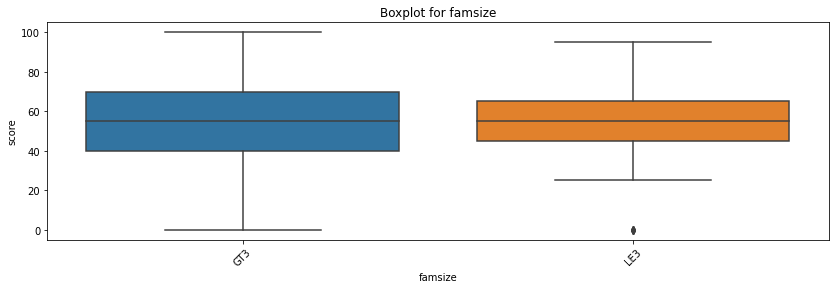

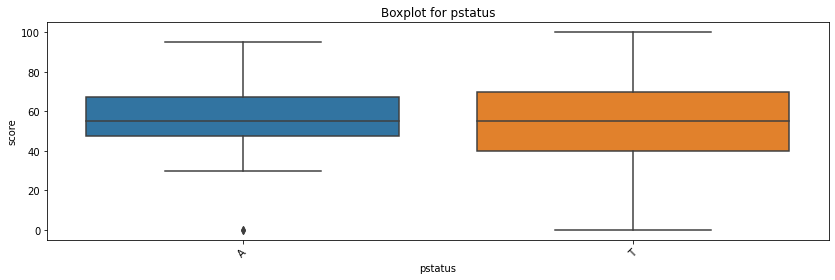

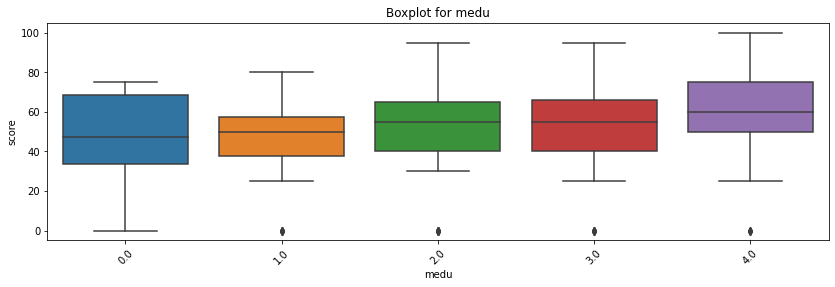

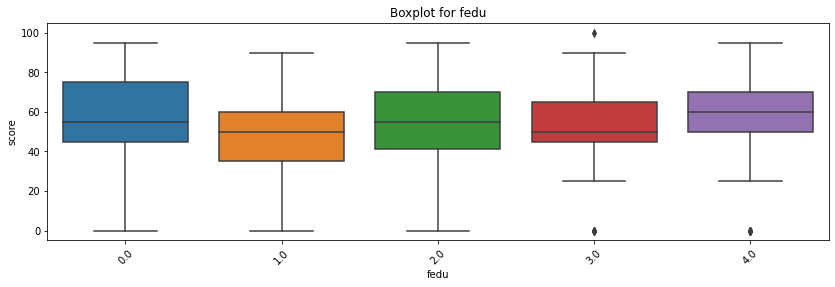

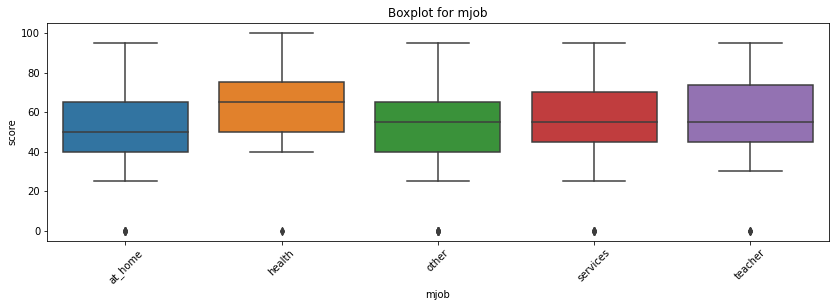

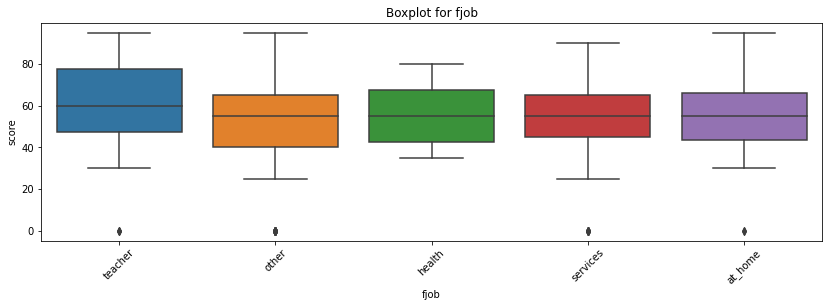

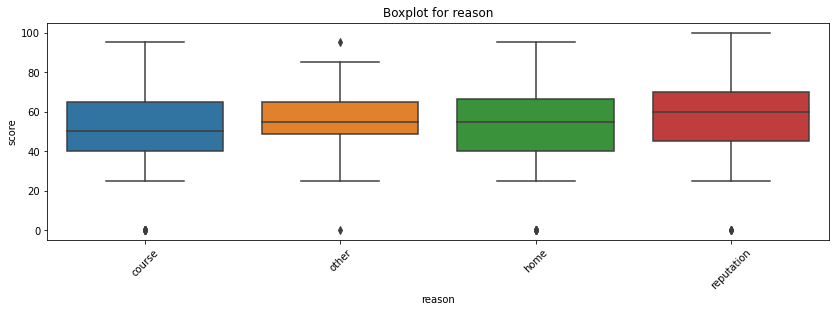

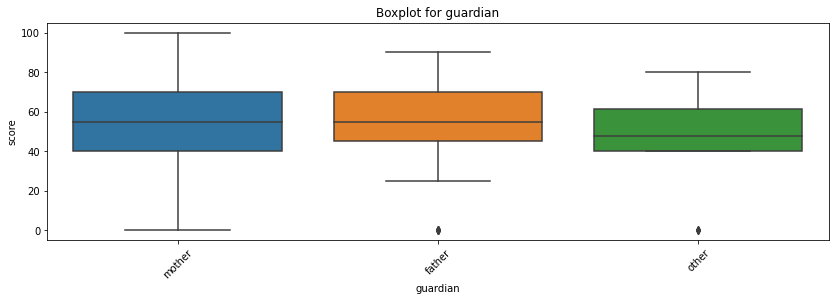

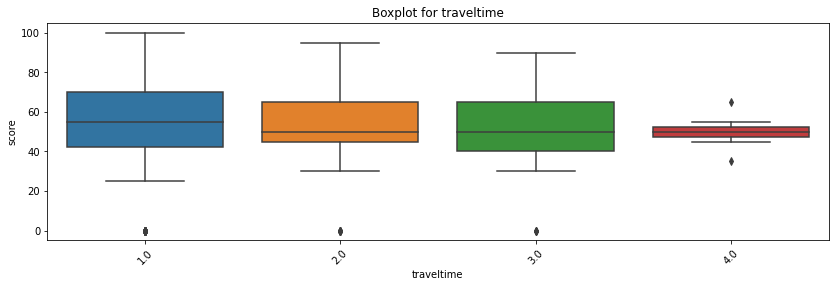

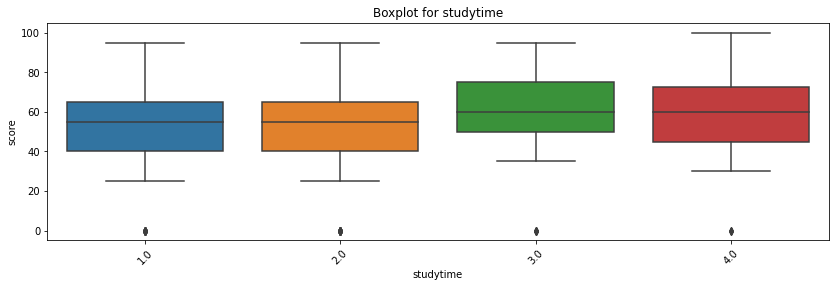

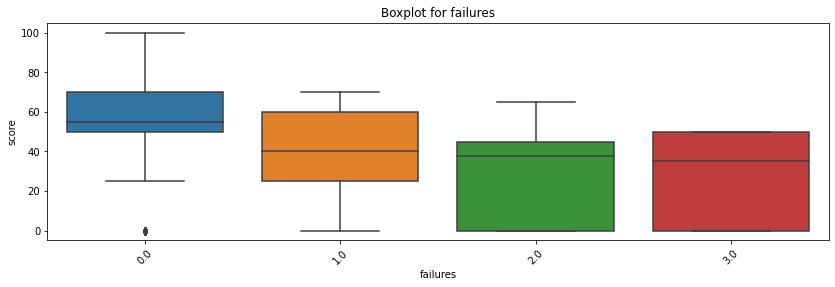

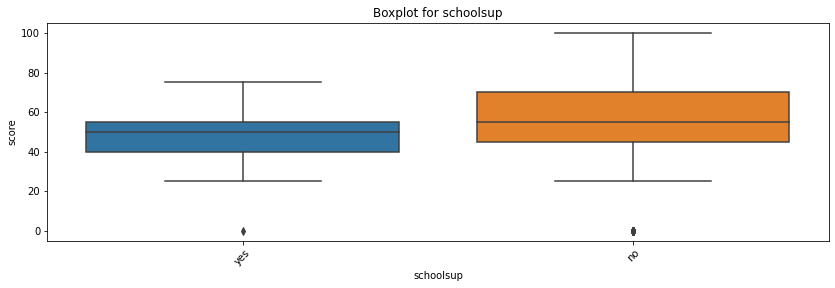

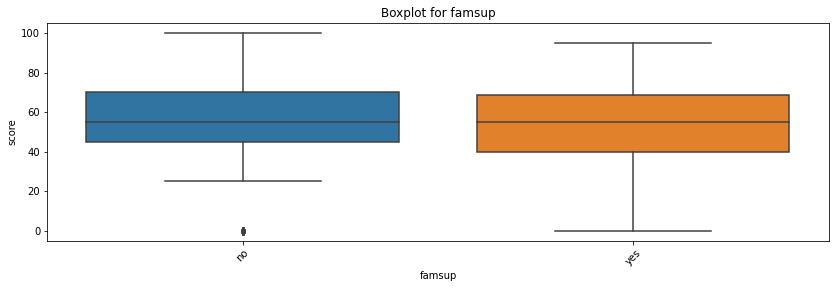

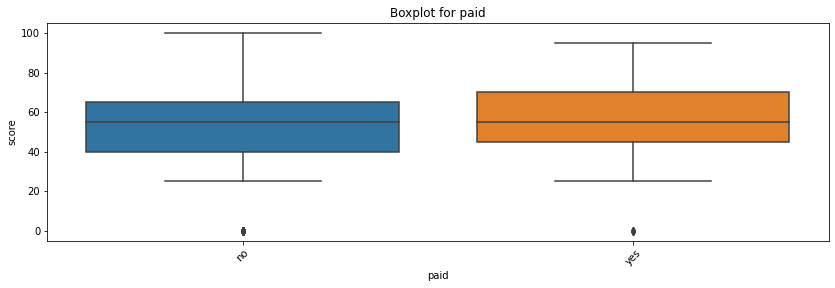

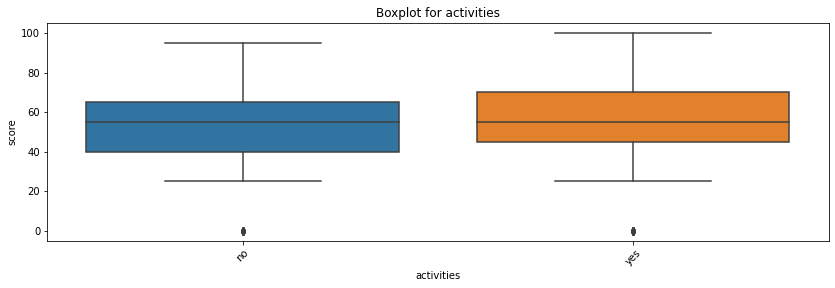

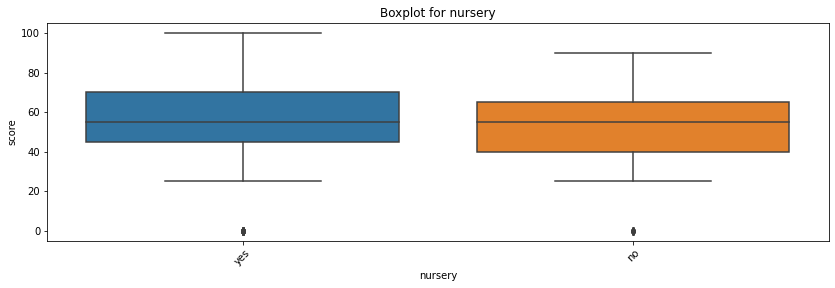

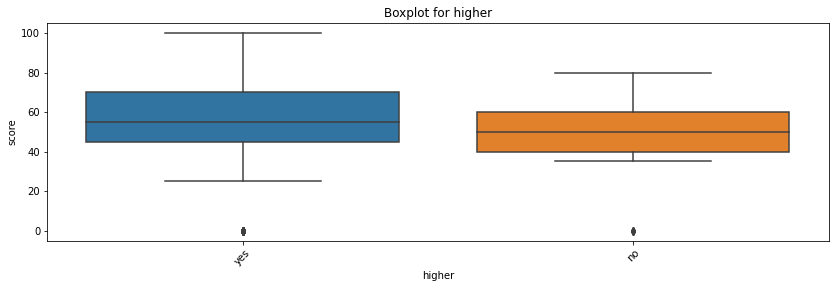

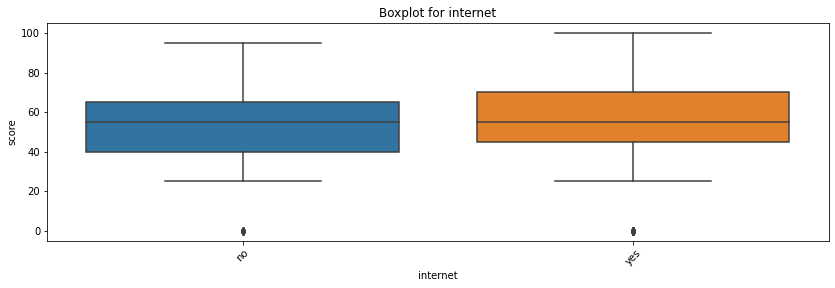

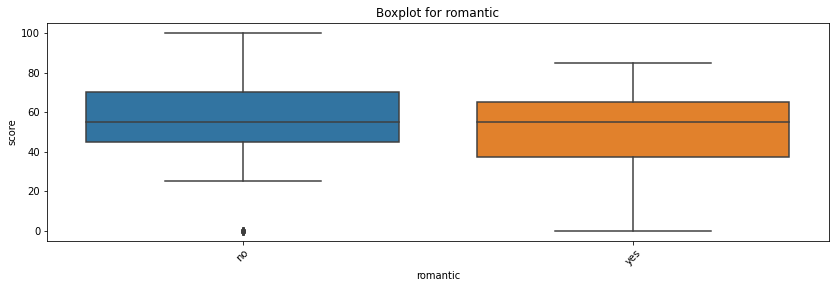

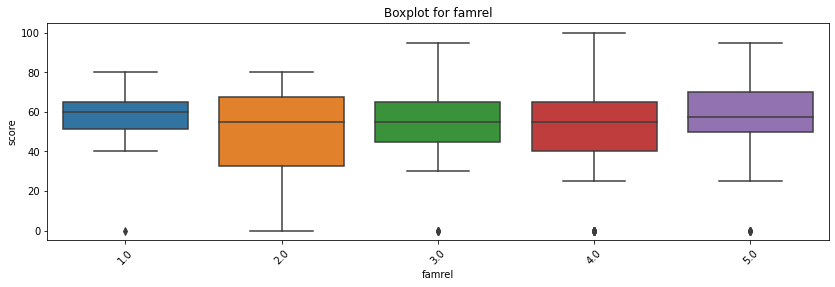

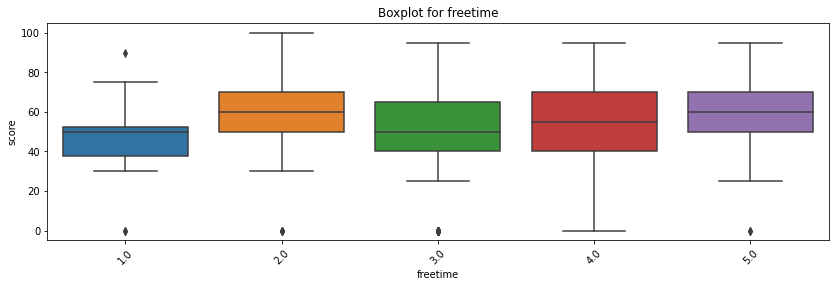

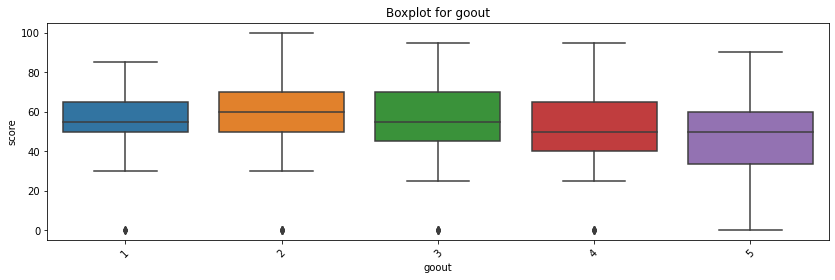

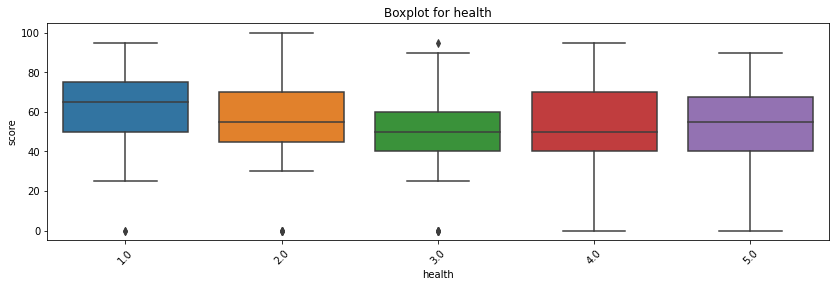

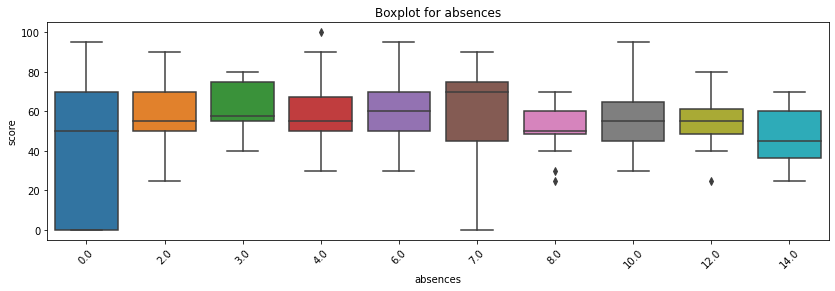

In [80]:
# Сделаем анализ номинативных переменных черех boxplot
for col in df.columns[~df.columns.isin(['score'])]:
    get_boxplot(col)

По графикам видно что следующие колонки: **school, sex, famsize, pstatus, reason, guardian, famsup, paid, activities, nursery, higher, internet, romantic** имеют слабое влияние на оценки или не имеют вовсе.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью **теста Стьюдента**. Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным параметрам неразличимы:

In [81]:
for col in df.columns[~df.columns.isin(['score'])]:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки absences


# 6. Сформулировать выводы относительно качества данных и тех переменных, которые будут использоваться в дальнейшем построении модели.

В результате EDA для анализа влияния на успеваемость детей по математике, ббыли выявлены следующие выводы:
В данных достаточно мало пустых значений. Выбросов не много, что позволяет сделать вывод что данные достаточчно чистые.
Итак:
- Успеваемость у мальчиков в среднем немного выше чем у девочек
- С возрастом учащиеся начинают учиться немного хуже
- Городские ученики учаться в среднем лучше чем из сельской местности
- Образование матери значительно влияет на успеваемость ребенка. 
- Количество учебных неудач (колонка failures) влияет на успеваемость ребенка очень сильно.
- Платные занятия влияют на успекваемость слабо
- Ученики думающие об высшем образовании отличаются более высокой успеваемостью, но в среднем не сильно.
- Ученики не состоящие в отношениях с противоположным полом учаться немного лучше.
- Колонка с количеством пропущенных занятий не дает полезной информации. Данные разбросаны. Построить модель на основании этих данных нельзя. Эту колонку лучше не использовать.